In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## SIFT keypoints

In [2]:
img1 = cv2.imread("img/2a.png")
newscale = img1.shape[0] / 500
newshape = ( int(img1.shape[1] / newscale), int(img1.shape[0] / newscale) )

img1 = cv2.resize(cv2.imread("img/2a.png", cv2.IMREAD_GRAYSCALE), newshape )
img2 = cv2.resize(cv2.imread("img/2b.png", cv2.IMREAD_GRAYSCALE), newshape )

#img1 = cv2.imread("img/2a.jpg")
#img2 = cv2.imread("img/2b.jpg")

In [3]:

# detect kepoints and their descriptor for 'img1' using SIFT
sift = cv2.SIFT_create()
kp1, dst1 = sift.detectAndCompute(img1, None)
# visualiziation
img_1 = cv2.drawKeypoints(img1, kp1, img1)
#plt.imshow(img_1)

In [4]:

# detect kepoints and their descriptor for 'img2' using SIFT
#sift = cv2.SIFT_create()
kp2, dst2 = sift.detectAndCompute(img2, None)
# visualiziation
img_2 = cv2.drawKeypoints(img2, kp2, img2)
#plt.imshow(img_2)

## Keypoint matching

In [5]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(dst1, dst2, k=2)

# Keep good matches: calculate distinctive image features
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [6]:
# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

## Drawing epipolar lines

In [7]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

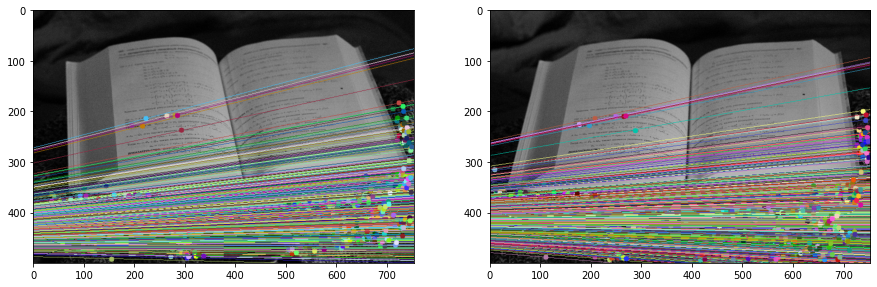

In [8]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,fundamental_matrix)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [9]:
# Stereo rectification (uncalibrated variant)
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1))

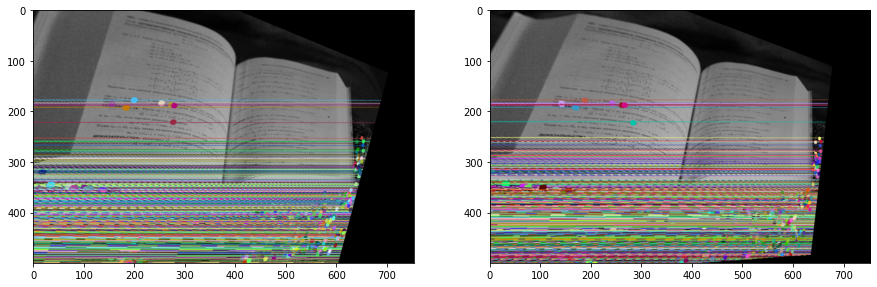

In [10]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(img5, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img3, H2, (w2, h2))
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(121),plt.imshow(img1_rectified)
plt.subplot(122),plt.imshow(img2_rectified)
plt.show()